
## First Step: Data Loading

We need to load TAVG data from the weather dataset. 
* The parquet file is ../../../weather_data/weather_1950_2025_combined.parquet
* We want to load years 1950-2025 of TAVG for all available stations
* The data should be in wide format with daily temperature values for each station-year combination.


In [1]:
import dask.dataframe as dd
# Load TAVG data for all available years (1950-2025)
weather_data_all_years = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet')
tavg_data = weather_data_all_years[weather_data_all_years['ELEMENT'] == 'TAVG']

print(f"Loaded {len(tavg_data)} TAVG records for all years")
#print(f"Years: {sorted(tavg_data['year'].unique())}")
#print(f"Stations: {tavg_data['ID'].nunique()}")


Loaded 295949 TAVG records for all years


In [2]:
import dask.dataframe as dd
# Load all available years of TAVG data
tavg_data = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet').query(
    "ELEMENT == 'TAVG' and 2000 <= year <= 2025"
) 
print("tavg_data shape:", tavg_data.shape)

print(f"Loaded {len(tavg_data)} TAVG records (all years)")
#print(f"Years: {sorted(tavg_data['year'].unique())}")
##print(f"Stations: {tavg_data['ID'].unique()}")



tavg_data shape: (Delayed('int-b95c5686-fc7f-4dc3-b8e5-cf8a6df5e5de'), 368)
Loaded 146730 TAVG records (all years)


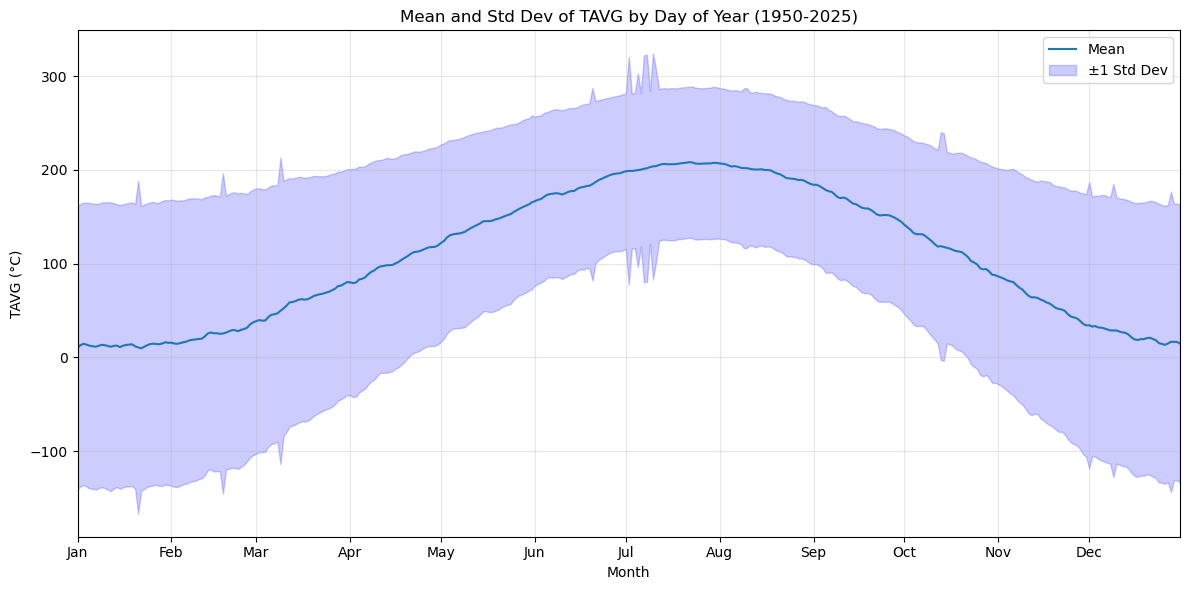

In [3]:

from dask_pca import plot_mean_std
# Use the function on the TAVG data
daily_means, daily_stds = plot_mean_std(tavg_data, title="Mean and Std Dev of TAVG by Day of Year (1950-2025)", ylabel="TAVG (°C)")



In [4]:
import dask.dataframe as dd

stations_df = dd.read_parquet("../weather_info/stations_dask.parquet")

print("stations_df columns:", stations_df.columns)


stations_df columns: Index(['station_id', 'latitude', 'longitude', 'elevation', 'state', 'name',
       'gsn_flag', 'hcn_crn_flag', 'wmo_id'],
      dtype='object')


In [5]:
# Join stations_df (Dask DataFrame) and tavg_data (assumed pandas DataFrame) on station_id <-> ID

# Step 1: Set indices for performance
print("Setting indices...")
stations_df_indexed = stations_df.set_index('station_id')
tavg_data_indexed = tavg_data.set_index('ID')

# Step 2: Optimize partition sizes
print("Optimizing partitions...")
stations_df_opt = stations_df_indexed.repartition(
    npartitions=max(1, len(stations_df_indexed) // 1000000)  # ~1M rows per partition
)
tavg_data_opt = tavg_data_indexed.repartition(
    npartitions=max(1, len(tavg_data_indexed) // 1000000)
)

# Step 3: Memory-efficient join
print("Performing optimized join...")
joined_df = stations_df_opt.join(tavg_data_opt, how='inner')

# Step 4: Optimize result partitioning
print("Optimizing result...")
def get_optimal_partitions(df):
    """Calculate optimal partitions based on data size"""
    n_rows = len(df)
    
    if n_rows < 1000000:  # < 1M rows
        return 4
    elif n_rows < 10000000:  # < 10M rows
        return 8
    elif n_rows < 100000000:  # < 100M rows
        return 16
    else:  # >= 100M rows
        return 32

optimal_partitions = get_optimal_partitions(joined_df)
joined_df = joined_df.repartition(npartitions=optimal_partitions)

# Step 5: Persist to avoid recomputation
print("Persisting result...")
joined_df = joined_df.persist()

print(f"Join complete! Result shape: {joined_df.shape}")
print(f"Repartitioned to {optimal_partitions} partitions")


Setting indices...
Optimizing partitions...
Performing optimized join...
Optimizing result...
Persisting result...
Join complete! Result shape: (Delayed('int-d092fc6d-f691-406e-a2f7-35b0cf4a98e3'), 375)
Repartitioned to 4 partitions


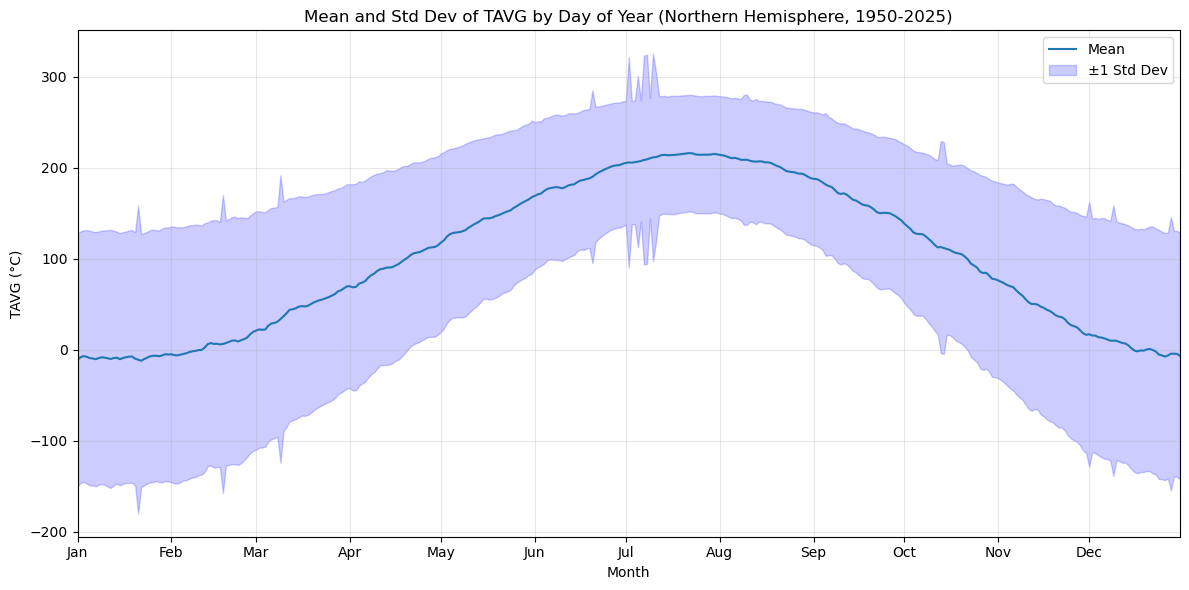

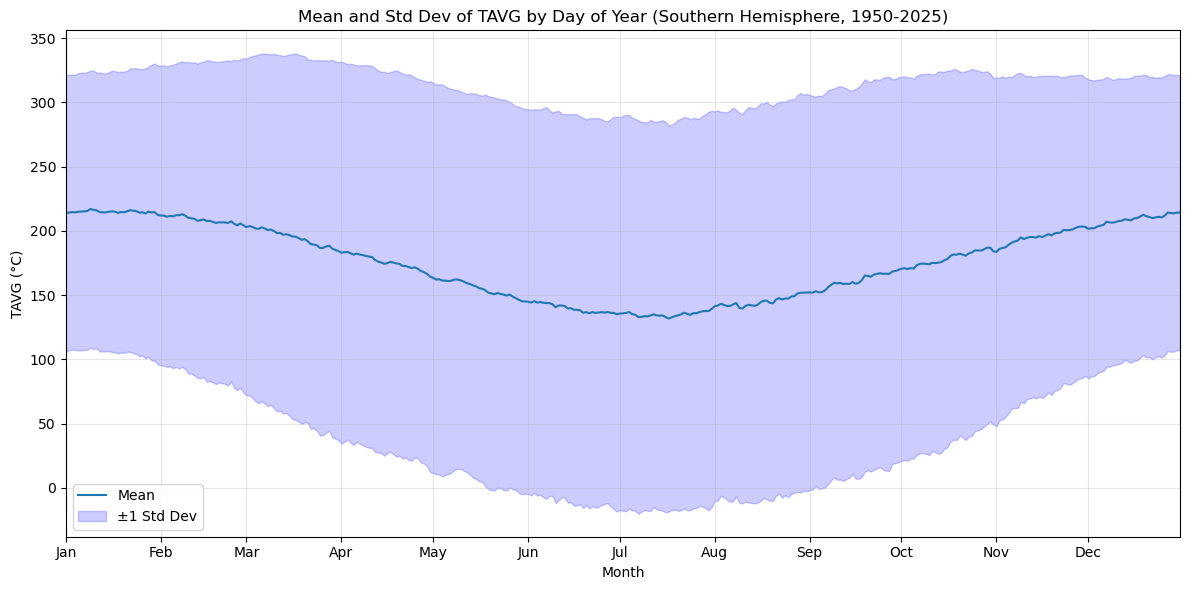

In [6]:
import matplotlib.pyplot as plt

# Compute hemisphere for each station based on latitude
joined_df['hemisphere'] = joined_df['latitude'].map(lambda lat: 'Northern' if lat >= 0 else 'Southern', meta=('latitude', 'object'))

# Use plot_mean_std for hemisphere subsets, store outputs
northern_df = joined_df[joined_df['hemisphere'] == 'Northern']
southern_df = joined_df[joined_df['hemisphere'] == 'Southern']

northern_mean, northern_std = plot_mean_std(
    northern_df,
    title="Mean and Std Dev of TAVG by Day of Year (Northern Hemisphere, 1950-2025)",
    ylabel="TAVG (°C)"
)

southern_mean, southern_std = plot_mean_std(
    southern_df,
    title="Mean and Std Dev of TAVG by Day of Year (Southern Hemisphere, 1950-2025)",
    ylabel="TAVG (°C)"
)


In [7]:
%load_ext autoreload
%autoreload 2


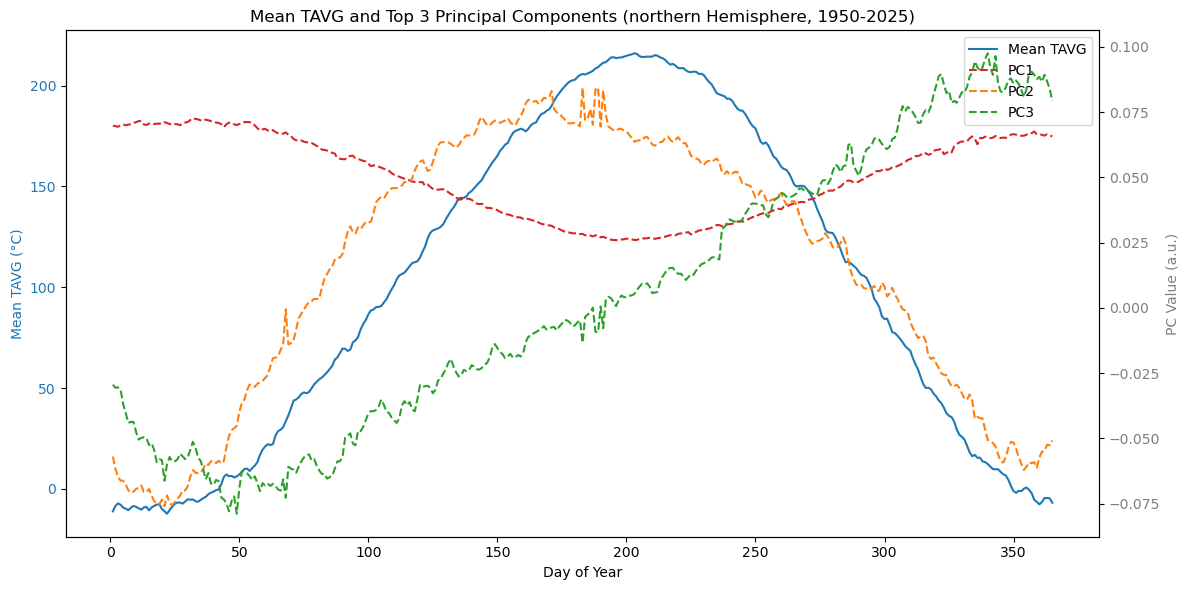

array([3.48843821e+08, 2.76917381e+07, 1.19711511e+07, 5.51557549e+06,
       4.69085087e+06, 3.21756719e+06, 2.52310799e+06, 2.32442821e+06,
       2.23149230e+06, 2.03939085e+06, 1.97591214e+06, 1.81703042e+06,
       1.67941688e+06, 1.65136589e+06, 1.52441133e+06, 1.43099081e+06,
       1.40986098e+06, 1.37800941e+06, 1.22631536e+06, 1.19680692e+06,
       1.16004155e+06, 1.11755097e+06, 1.08706861e+06, 1.03822030e+06,
       1.00060487e+06, 9.83623798e+05, 9.27052860e+05, 9.02289193e+05,
       8.83026859e+05, 8.46295263e+05, 8.36493916e+05, 7.84522584e+05,
       7.73317989e+05, 7.55133021e+05, 7.45621461e+05, 7.02200748e+05,
       6.89489853e+05, 6.78349596e+05, 6.70468233e+05, 6.34143239e+05,
       6.21865679e+05, 6.13782286e+05, 5.92290046e+05, 5.86927416e+05,
       5.65477142e+05, 5.49509848e+05, 5.40279968e+05, 5.28447908e+05,
       5.17150806e+05, 5.04487081e+05, 4.98205026e+05, 4.89694933e+05,
       4.71905741e+05, 4.68208683e+05, 4.52953215e+05, 4.42675832e+05,
      

In [8]:
# Use the general-purpose plot_mean_and_pcs function for northern hemisphere data
from dask_pca import plot_mean_and_pcs
import numpy as np

# Prepare the data: convert northern_df to array format
northern_df_computed = northern_df.compute()
day_cols = [f'day_{i}' for i in range(1, 366)]
northern_data = northern_df_computed[day_cols].values

# Create x-axis values (days of year)
days = np.arange(1, 366)

# Use the general-purpose function
mean, components, explained_variances = plot_mean_and_pcs(
    data=northern_data,
    n_components=3,
    title='Mean TAVG and Top 3 Principal Components (northern Hemisphere, 1950-2025)',
    xlabel='Day of Year',
    ylabel='Mean TAVG (°C)',
    signal_name='TAVG',
    x_values=days,
    figsize=(12, 6)
)

explained_variances


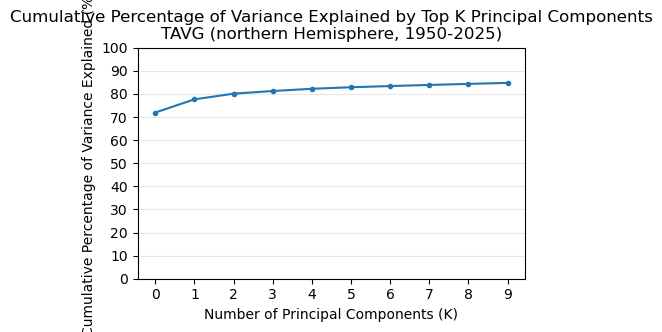

In [9]:
# Compute and plot the cumulative percentage of variance explained by the top K eigenvectors for TAVG in the northern hemisphere

# Calculate explained variance ratio (percentage)
explained_variance_ratio = (explained_variances / explained_variances.sum()).flatten() * 100

# Compute cumulative sum as cumulative percentage explained
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative percentage of variance explained as a function of K
plt.figure(figsize=(5,3))
plt.plot(range(10), cumulative_explained_variance[:10], marker='.')
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Cumulative Percentage of Variance Explained (%)')
plt.title('Cumulative Percentage of Variance Explained by Top K Principal Components\nTAVG (northern Hemisphere, 1950-2025)')
plt.xticks(range(10))
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
import pickle

# Save the mean and eigenvectors (principal components) to tavg.pkl
with open("tavg.pkl", "wb") as f:
    pickle.dump({"mean": mean, "components": components}, f)


: 